In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,Bidirectional,TimeDistributed
from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import ta as ta                                                        # technical analysis library
from scipy.stats import mannwhitneyu


# Load the dataset

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [6]:
df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [7]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [8]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [9]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [10]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [11]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [12]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [13]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [14]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [15]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# Create classes

In [17]:
# create a column to indicate the price movement: 1 means the price has increased compared to the previous day, 0 means the price has decreased

movement = []

for i in range(len(df)-1):

    if df['Close'][i+1] < df['Close'][i]:
        movement.append(0)
  
    else:
        movement.append(1)


In [18]:
# datapoint 0 in the dataset (2017-08-17) will be dropped because there is no price information prior to this day so it can not be put into a class.
df.drop(df.index[0], inplace=True)
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29
2017-08-22,2.454426e+06,321.04,330.41,144.21,309.80


In [19]:
df['Price Movement'] = np.array(movement)

In [20]:
df

,Volume,Open,High,Low,Close,Price Movement
Close Date,,,,,,
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96,0
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91,0
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10,1
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29,1
2017-08-22,2.454426e+06,321.04,330.41,144.21,309.80,0
...,...,...,...,...,...,...
2021-06-24,1.377800e+09,1967.95,2036.61,1884.79,1989.52,1
2021-06-25,1.612557e+09,1989.53,2019.99,1791.22,1808.82,0
2021-06-26,1.478551e+09,1808.97,1852.80,1717.32,1829.64,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1411 entries, 2017-08-18 to 2021-06-28
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volume          1411 non-null   float64
 1   Open            1411 non-null   float64
 2   High            1411 non-null   float64
 3   Low             1411 non-null   float64
 4   Close           1411 non-null   float64
 5   Price Movement  1411 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 71.7 KB


# Split dataset into training, validation and testing datasets for optimisation

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I'll be splitting the data into three sets (Training, Validation and Test)  as per the holdout method to help with determining the generalisation ability of the model during model selection. 
#### 61.45% of the data will be used for training, 12.7% will be used as the validation set and the remaining 25.85% will be used as the test set

In [23]:
split = int(len(df)*0.6145)
training_set = df[:split]      # 18/8/2017 - 1/1/2020

subset = df[split:]
split2 = int(len(subset)*0.3303)

val_set = subset[:split2]      # 2/1/2020 - 28/6/2020
test_set = subset[split2:]     # 29/6/2020 - 28/6/2021

In [24]:
print('Training: ', training_set.shape, '\nValidation: ', val_set.shape, '\nTest: ', test_set.shape)

Training:  (867, 6) 
Validation:  (179, 6) 
Test:  (365, 6)


# Split the data into X variables and y targets

In [25]:
# the x values will contain the first 5 features in the dataset and the y value will contain only the target feature to predict (price movement) 

X_training = (training_set.iloc[:, :-1]).values.reshape(training_set.shape[0],training_set.shape[1]-1)
y_training = (training_set.iloc[:, -1]).values.reshape(training_set.shape[0],1)

print(X_training.shape, y_training.shape)

X_valid = (val_set.iloc[:, :-1]).values.reshape(val_set.shape[0],val_set.shape[1]-1)
y_valid = (val_set.iloc[:, -1]).values.reshape(val_set.shape[0],1)

print(X_valid.shape, y_valid.shape)

X_testing = (test_set.iloc[:, :-1]).values.reshape(test_set.shape[0],test_set.shape[1]-1)
y_testing = (test_set.iloc[:, -1]).values.reshape(test_set.shape[0],1)

print(X_testing.shape, y_testing.shape)

(867, 5) (867, 1)
(179, 5) (179, 1)
(365, 5) (365, 1)


# I will check how imbalanced the classes are in each of the datasets' target vectors. 
#### I am following a Keras tutorial on how to check for and deal with imbalanced class sizes when training neural networks for classification tasks:
https://keras.io/examples/structured_data/imbalanced_classification/


In [27]:
print('TRAINING SET\n', 'Count:\n', training_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',training_set['Price Movement'].value_counts(normalize=True))
print('\nVALIDATION SET\n', 'Count:\n', val_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',val_set['Price Movement'].value_counts(normalize=True))
print('\nTESTING SET\n', 'Count:\n', test_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',test_set['Price Movement'].value_counts(normalize=True))


TRAINING SET
 Count:
 0    445
1    422
Name: Price Movement, dtype: int64 

Relative Frequencies:
 0    0.513264
1    0.486736
Name: Price Movement, dtype: float64

VALIDATION SET
 Count:
 1    92
0    87
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.513966
0    0.486034
Name: Price Movement, dtype: float64

TESTING SET
 Count:
 1    213
0    152
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.583562
0    0.416438
Name: Price Movement, dtype: float64


In [48]:
class_labels = pd.unique(df['Price Movement'])
train_count = training_set['Price Movement'].value_counts()
val_count = val_set['Price Movement'].value_counts()
test_count = test_set['Price Movement'].value_counts()

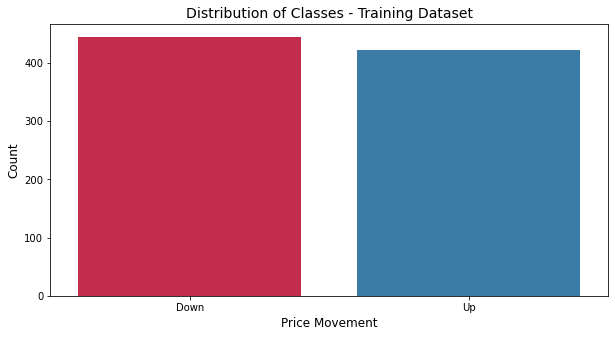

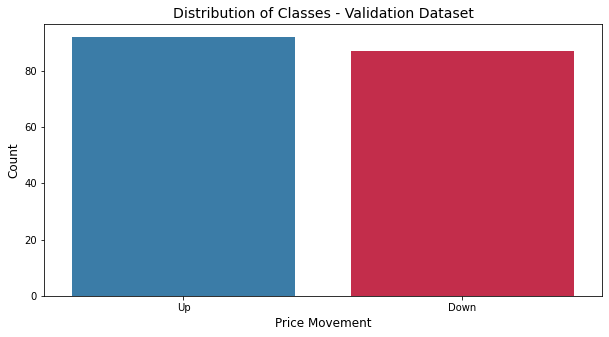

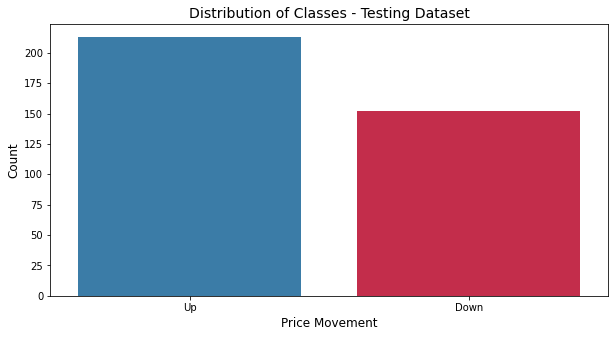

In [57]:
plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= train_count , palette=["#2980b9" if (x < max(train_count)) else '#dc143c' for x in train_count])
plt.title('Distribution of Classes - Training Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Up', 'Down'], y= val_count, palette=["#dc143c" if (x < max(val_count)) else '#2980b9' for x in val_count])
plt.title('Distribution of Classes - Validation Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Up', 'Down'], y= test_count, palette=["#dc143c" if (x < max(test_count)) else '#2980b9' for x in test_count])
plt.title('Distribution of Classes - Testing Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler from scikit-learn to do this.
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [27]:
Xscaler = MinMaxScaler(feature_range=(0,1))
yscaler = MinMaxScaler(feature_range=(0,1))

X_train = Xscaler.fit_transform(X_training)
y_train = yscaler.fit_transform(y_training)

X_val = Xscaler.fit_transform(X_valid)
y_val = yscaler.fit_transform(y_valid)

X_test = Xscaler.fit_transform(X_testing)
y_test = yscaler.fit_transform(y_testing)

## Prepare data for multi-step LSTM
##### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [28]:
# stack the data horizontally

train_stacked = np.hstack((X_training, y_training))
print ("Stacked Training Data Shape: " , train_stacked.shape)

val_stacked = np.hstack((X_valid, y_valid))
print ("Stacked Validation Data Shape: " , val_stacked.shape)

test_stacked = np.hstack((X_testing, y_testing))
print ("Stacked Test Data Shape: " , test_stacked.shape)

Stacked Training Data Shape:  (867, 6)
Stacked Validation Data Shape:  (179, 6)
Stacked Test Data Shape:  (365, 6)


In [29]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [30]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 14

# run function
X_train, y_train = create_sequences(train_stacked, n_steps_in, n_steps_out)
print ("X train sequences: " , X_train.shape, "y train sequences" , y_train.shape)            

X_val, y_val = create_sequences(val_stacked, n_steps_in, n_steps_out)
print ("X val sequences: " , X_val.shape, "y val sequences" , y_val.shape) 

X_test, y_test = create_sequences(test_stacked, n_steps_in, n_steps_out)
print ("X test sequences: " , X_test.shape, "y test sequences" , y_test.shape)      

X train sequences:  (841, 14, 5) y train sequences (841, 14)
X val sequences:  (153, 14, 5) y val sequences (153, 14)
X test sequences:  (339, 14, 5) y test sequences (339, 14)


# Model Building on CoLab
### I will tune the model using Keras Tuner

##### https://www.danielpovey.com/files/2017_interspeech_dropout.pdf 
##### https://www.tensorflow.org/tutorials/keras/keras_tuner#define_the_model
##### Using Bidirectional wrappers to create a Bidirectional LSTM: https://keras.io/api/layers/recurrent_layers/bidirectional/
##### Code for classification Bidirectional LSTM adapted from: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [31]:
n_features = X_train.shape[2]

# I need to define the features during model creation so that the Keras Tuner can find the optimum values

# create LSTM model
def create_model(hp):

  model = Sequential()
  # Tuner for number of nodules/units in the model layers
  model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True), input_shape=(n_steps_in, n_features),
                          merge_mode=hp.Choice('merge_mode', values=['sum', 'mul', 'concat', 'ave'])))
 
  for i in range(hp.Int('n_layers', 1, 3)):  # adding additional layers.
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True), 
            merge_mode=hp.Choice('merge_mode', values=['sum', 'mul', 'concat', 'ave'])))
    model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))

  model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True), 
            merge_mode=hp.Choice('merge_mode', values=['sum', 'mul', 'concat', 'ave'])))
  model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))
  model.add(TimeDistributed(Dense(1, activation='sigmoid')))
  model.compile(loss='binary_crossentropy' , optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.0001, 0.00001, 0.000001])) , metrics=['accuracy'])

  return model




# Hypertune the model

In [32]:
# I need to set up the tuner with the correct objective function which in this case is to minimise the validation loss (i.e. the generalisation error)

tuner = kt.RandomSearch(create_model, objective = "val_accuracy", max_trials=10)

# Search for the best parameters

In [33]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
merge_mode (Choice)
{'default': 'sum', 'conditions': [], 'values': ['sum', 'mul', 'concat', 'ave'], 'ordered': False}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dropout (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5, 0.7], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 1e-05, 1e-06], 'ordered': True}


In [35]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

In [36]:
# The tuner will now search across the potential values for each hyperparameter and select the best combination

tuner.search(X_train , y_train , epochs=100 , validation_data=(X_val, y_val)  ,shuffle=False, callbacks=[stop_early])

Trial 10 Complete [00h 00m 38s]
val_accuracy: 0.5014005899429321

Best val_accuracy So Far: 0.523809552192688
Total elapsed time: 00h 07m 24s
INFO:tensorflow:Oracle triggered exit


# Results of hypertuning

In [38]:
# This will provide a list of the top 10 best models in ascending order, with their respective parameters. 
# Model 1 at the top of the list is the optimised model that I will use for training and testing.

tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 90
merge_mode: ave
n_layers: 2
dropout: 0.3
learning_rate: 1e-05
Score: 0.523809552192688
Trial summary
Hyperparameters:
units: 10
merge_mode: sum
n_layers: 2
dropout: 0.7
learning_rate: 1e-06
Score: 0.5168067812919617
Trial summary
Hyperparameters:
units: 90
merge_mode: ave
n_layers: 3
dropout: 0.3
learning_rate: 0.0001
Score: 0.5158730149269104
Trial summary
Hyperparameters:
units: 70
merge_mode: concat
n_layers: 3
dropout: 0.3
learning_rate: 1e-05
Score: 0.5098039507865906
Trial summary
Hyperparameters:
units: 40
merge_mode: concat
n_layers: 3
dropout: 0.5
learning_rate: 1e-05
Score: 0.5014005899429321
Trial summary
Hyperparameters:
units: 40
merge_mode: concat
n_layers: 2
dropout: 0.5
learning_rate: 1e-06
Score: 0.49859943985939026
Trial summary
Hyperparameters:
units: 70
merge_mode: sum
n_layers: 1
dropout: 0.3
learning_rate: 1e

In [50]:
best_model = tuner.get_best_models(num_models=1)[0]

In [51]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 90)            69120     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 90)            130320    
_________________________________________________________________
dropout (Dropout)            (None, 14, 90)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 14, 90)            130320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 90)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 14, 90)            130320    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 90)            0

#Now that the optimised model has been selected, I will create 4 classification models to compare to 4 regression models that were made earlier.


#**1. Baseline Classification BiLSTM Model**
### Train and test the baseline model 5 times to get a list of scores to use later for statistical comparison.


Training Number  0
Test Accuracy:  55.900000000000006 || Test F-score:  0.521 


Training Number  1
Test Accuracy:  55.7 || Test F-score:  0.522 


Training Number  2
Test Accuracy:  53.6 || Test F-score:  0.502 


Training Number  3
Test Accuracy:  55.50000000000001 || Test F-score:  0.519 


Training Number  4
Test Accuracy:  53.6 || Test F-score:  0.499 


Baseline Classification BiLSTM Model -- 
Average Test Accuracy:  54.900000000000006  ||  Average Test F-score:  0.513


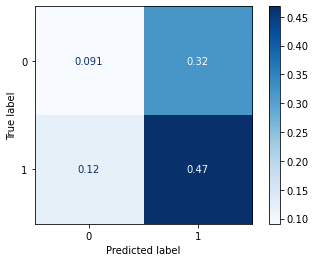

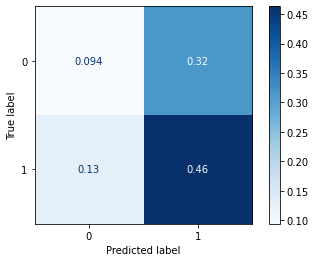

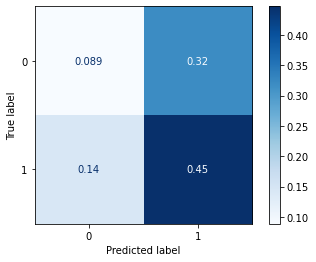

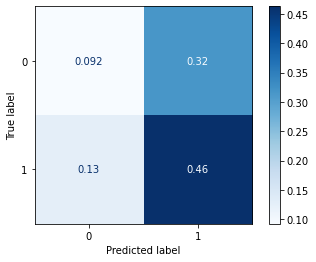

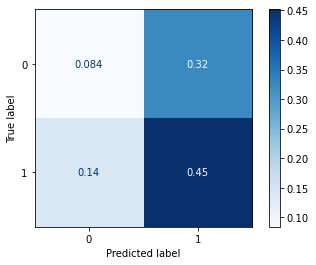

In [121]:
acc_list = []
fscore_list = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  best_model.fit(X_train , y_train , epochs=100 , verbose=0 , validation_data=(X_val, y_val) ,shuffle=False)

  # predict

  test_pred = best_model.predict(X_test)

  # generate the metric scores

  y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])

  test_loss, test_accuracy = best_model.evaluate(X_test, y_test_reshaped, verbose = 0)

  test_pred = test_pred.astype(int).reshape(-1)
  y_test_flat = y_test.astype(int).reshape(-1)

  fscore = f1_score(y_test_flat, test_pred, average='weighted')

  print('Test Accuracy: ', float('%.3g' % test_accuracy)*100, '|| Test F-score: ', float('%.3g' % fscore), '\n')

  acc_list.append(test_accuracy)
  fscore_list.append(fscore)

  matrix = confusion_matrix(y_test_flat, test_pred, normalize='all')
  matrix_image = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0,1])
  matrix_image.plot(cmap='Blues') 

print('\nBaseline Classification BiLSTM Model -- \nAverage Test Accuracy: ', float('%.3g' % np.mean(acc_list))*100, 
      ' ||  Average Test F-score: ', float('%.3g' % np.mean(fscore_list)))


# **2. BTC input - Classification Model**

### Since I am going to be using BTC prices as the input for this model, I need to load the BTC dataset and carry out the same pre-processing steps as above on the BTC data.

Load the dataset

In [53]:
from google.colab import files
import io
uploaded = files.upload()

Saving btc_data.csv to btc_data.csv


In [54]:
btc_data = pd.read_csv(io.BytesIO(uploaded['btc_data.csv']), header=None)

In [59]:
btc_data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

Preprocessing steps

In [60]:
btc_data['Open Date'] = pd.to_datetime(btc_data['Open Time'], unit='ms')
btc_data['Close Date'] = pd.to_datetime(btc_data['Close Time'], unit='ms')

In [61]:
btc_data['Close Date'] = btc_data['Close Date'].dt.normalize()

In [62]:
btc_data.drop(['Open Time', 'Close Time', 'Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [63]:
btc_data.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [64]:
btc_data.set_index('Close Date', inplace=True)
btc_data.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,3.454770e+06
2017-08-18,4285.08,4371.52,3938.77,4108.37,5.086958e+06
2017-08-19,4108.37,4184.69,3850.00,4139.98,1.549484e+06
2017-08-20,4120.98,4211.08,4032.62,4086.29,1.930364e+06
2017-08-21,4069.13,4119.62,3911.79,4016.00,2.797232e+06


In [65]:
columns = btc_data.columns.tolist()
columns = columns[-1:] + columns[:-1]
btc_data = btc_data[columns]

In [66]:
btc_data.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,3.454770e+06,4261.48,4485.39,4200.74,4285.08
2017-08-18,5.086958e+06,4285.08,4371.52,3938.77,4108.37
2017-08-19,1.549484e+06,4108.37,4184.69,3850.00,4139.98
2017-08-20,1.930364e+06,4120.98,4211.08,4032.62,4086.29
2017-08-21,2.797232e+06,4069.13,4119.62,3911.79,4016.00


In [67]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2017-08-17 to 2021-08-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1461 non-null   float64
 1   Open    1461 non-null   float64
 2   High    1461 non-null   float64
 3   Low     1461 non-null   float64
 4   Close   1461 non-null   float64
dtypes: float64(5)
memory usage: 68.5 KB


I need the BTC dataset to end on 28-6-2021 like the ETH dataset, so I will have to drop some rows.

In [68]:
btc_data = pd.DataFrame(btc_data.iloc[0:1412,:])

In [69]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


 ## Create classes

In [70]:
# create a column to indicate the price movement: 1 means the price has increased compared to the previous day, 0 means the price has decreased

btc_movement = []

for i in range(len(btc_data)-1):

    if btc_data['Close'][i+1] < btc_data['Close'][i]:
        btc_movement.append(0)
  
    else:
        btc_movement.append(1)

In [71]:
# datapoint 0 in the dataset (2017-08-17) will be dropped because there is no price information prior to this day so it can not be put into a class.
btc_data.drop(btc_data.index[0], inplace=True)
btc_data.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-18,5.086958e+06,4285.08,4371.52,3938.77,4108.37
2017-08-19,1.549484e+06,4108.37,4184.69,3850.00,4139.98
2017-08-20,1.930364e+06,4120.98,4211.08,4032.62,4086.29
2017-08-21,2.797232e+06,4069.13,4119.62,3911.79,4016.00
2017-08-22,3.752506e+06,4016.00,4104.82,3400.00,4040.00


In [72]:
btc_data['Price Movement'] = np.array(btc_movement) 

In [73]:
btc_data

,Volume,Open,High,Low,Close,Price Movement
Close Date,,,,,,
2017-08-18,5.086958e+06,4285.08,4371.52,3938.77,4108.37,0
2017-08-19,1.549484e+06,4108.37,4184.69,3850.00,4139.98,1
2017-08-20,1.930364e+06,4120.98,4211.08,4032.62,4086.29,0
2017-08-21,2.797232e+06,4069.13,4119.62,3911.79,4016.00,0
2017-08-22,3.752506e+06,4016.00,4104.82,3400.00,4040.00,1
...,...,...,...,...,...,...
2021-06-24,2.925373e+09,33675.07,35298.00,32286.57,34663.09,1
2021-06-25,3.846121e+09,34663.08,35500.00,31275.00,31584.45,0
2021-06-26,3.376415e+09,31576.09,32730.00,30151.00,32283.65,1


In [74]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1411 entries, 2017-08-18 to 2021-06-28
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volume          1411 non-null   float64
 1   Open            1411 non-null   float64
 2   High            1411 non-null   float64
 3   Low             1411 non-null   float64
 4   Close           1411 non-null   float64
 5   Price Movement  1411 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 77.2 KB


Split the data into the same sized sets as the ETH data

In [74]:
btc_split = int(len(btc_data)*0.6145)
btc_training_set = btc_data[:btc_split]      

btc_subset = btc_data[btc_split:]
btc_split2 = int(len(btc_subset)*0.3303)

btc_val_set = btc_subset[:btc_split2]      
btc_test_set = btc_subset[btc_split2:]     


In [75]:
print('BTC Training: ', btc_training_set.shape, '\nBTC Validation: ', btc_val_set.shape, '\nBTC Test: ', btc_test_set.shape)

BTC Training:  (867, 6) 
BTC Validation:  (179, 6) 
BTC Test:  (365, 6)


In [76]:
btc_X_training = (btc_training_set.iloc[:, :-1]).values.reshape(btc_training_set.shape[0],btc_training_set.shape[1]-1)
btc_y_training = (btc_training_set.iloc[:, -1]).values.reshape(btc_training_set.shape[0],1)

print(btc_X_training.shape, btc_y_training.shape)

btc_X_valid = (btc_val_set.iloc[:, :-1]).values.reshape(btc_val_set.shape[0],btc_val_set.shape[1]-1)
btc_y_valid = (btc_val_set.iloc[:, -1]).values.reshape(btc_val_set.shape[0],1)

print(btc_X_valid.shape, btc_y_valid.shape)

btc_X_testing = (btc_test_set.iloc[:, :-1]).values.reshape(btc_test_set.shape[0],btc_test_set.shape[1]-1)
btc_y_testing = (btc_test_set.iloc[:, -1]).values.reshape(btc_test_set.shape[0],1)

print(btc_X_testing.shape, btc_y_testing.shape)

(867, 5) (867, 1)
(179, 5) (179, 1)
(365, 5) (365, 1)


I will check for class imbalance again

In [77]:
print('BTC TRAINING SET\n', 'Count:\n', btc_training_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',btc_training_set['Price Movement'].value_counts(normalize=True))
print('\nVALIDATION SET\n', 'Count:\n', btc_val_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',btc_val_set['Price Movement'].value_counts(normalize=True))
print('\nTESTING SET\n', 'Count:\n', btc_test_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',btc_test_set['Price Movement'].value_counts(normalize=True))


BTC TRAINING SET
 Count:
 1    450
0    417
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.519031
0    0.480969
Name: Price Movement, dtype: float64

VALIDATION SET
 Count:
 1    98
0    81
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.547486
0    0.452514
Name: Price Movement, dtype: float64

TESTING SET
 Count:
 1    201
0    164
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.550685
0    0.449315
Name: Price Movement, dtype: float64


In [78]:
btc_class_labels = pd.unique(btc_data['Price Movement'])
btc_train_count = btc_training_set['Price Movement'].value_counts()
btc_val_count = btc_val_set['Price Movement'].value_counts()
btc_test_count = btc_test_set['Price Movement'].value_counts()

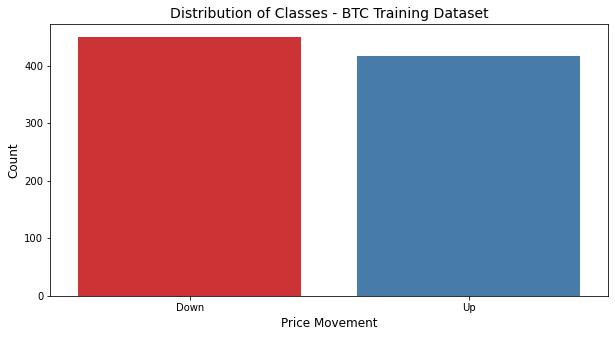

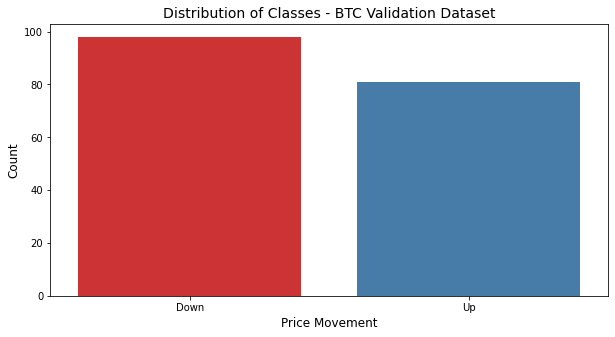

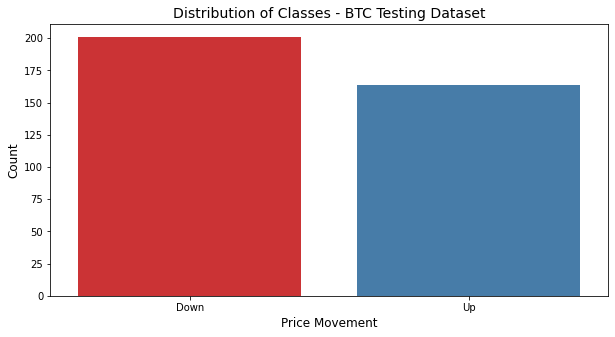

In [81]:
plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= btc_train_count, palette='Set1')
plt.title('Distribution of Classes - BTC Training Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y=btc_val_count , palette='Set1')
plt.title('Distribution of Classes - BTC Validation Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y=btc_test_count, palette='Set1')
plt.title('Distribution of Classes - BTC Testing Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

Normalisation

In [81]:
btc_Xscaler = MinMaxScaler(feature_range=(0,1))
btc_yscaler = MinMaxScaler(feature_range=(0,1))

btc_X_train = btc_Xscaler.fit_transform(btc_X_training)
btc_y_train = btc_yscaler.fit_transform(btc_y_training)

btc_X_val = btc_Xscaler.fit_transform(btc_X_valid)
btc_y_val = btc_yscaler.fit_transform(btc_y_valid)

btc_X_test = btc_Xscaler.fit_transform(btc_X_testing)
btc_y_test = btc_yscaler.fit_transform(btc_y_testing)

Preparing the sequences for multistep LSTM

In [82]:
# stack the data horizontally

btc_train_stacked = np.hstack((btc_X_train, btc_y_train))
print ("Stacked BTC Training Data Shape: " , btc_train_stacked.shape)

btc_val_stacked = np.hstack((btc_X_valid, btc_y_valid))
print ("Stacked BTC Validation Data Shape: " , btc_val_stacked.shape)

btc_test_stacked = np.hstack((btc_X_test, btc_y_test))
print ("Stacked BTC Test Data Shape: " , btc_test_stacked.shape)

Stacked BTC Training Data Shape:  (867, 6)
Stacked BTC Validation Data Shape:  (179, 6)
Stacked BTC Test Data Shape:  (365, 6)


In [83]:
# choose a number of time steps 
#n_steps_in, n_steps_out = 14, 14    # same timesteps as ETH

# run function
btc_X_train, btc_y_train = create_sequences(btc_train_stacked, n_steps_in, n_steps_out)
print ("BTC X train sequences: " , btc_X_train.shape, "BTC y train sequences" , btc_y_train.shape)      

btc_X_val, btc_y_val = create_sequences(btc_val_stacked, n_steps_in, n_steps_out)
print ("BTC X val sequences: " , btc_X_val.shape, "BTC y val sequences" , btc_y_val.shape) 

btc_X_test, btc_y_test = create_sequences(btc_test_stacked, n_steps_in, n_steps_out)
print ("BTC X test sequences: " , btc_X_test.shape, "BTC y test sequences" , btc_y_test.shape)    

BTC X train sequences:  (841, 14, 5) BTC y train sequences (841, 14)
BTC X val sequences:  (153, 14, 5) BTC y val sequences (153, 14)
BTC X test sequences:  (339, 14, 5) BTC y test sequences (339, 14)


#### I will create a Bidirectional LSTM Classification Model with the same optimal parameters and architecture selected from hypertuning. This model will be trained on BTC only.

In [86]:
btc_n_features = btc_X_train.shape[2]

btc_model = Sequential()
btc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), input_shape=(n_steps_in, btc_n_features), merge_mode='ave'))
btc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
btc_model.add(Dropout(0.3))
btc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
btc_model.add(Dropout(0.3))
btc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
btc_model.add(Dropout(0.3))
btc_model.add(TimeDistributed(Dense(1, activation='sigmoid')))
btc_model.compile(loss='binary_crossentropy' , optimizer=keras.optimizers.Adam(learning_rate= 0.00001) , metrics=['accuracy'])

In [87]:
btc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 14, 90)            69120     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 14, 90)            130320    
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 90)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 14, 90)            130320    
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 90)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 14, 90)            130320    
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 90)           

#### Train and test the model 5 times to get a list of scores to use for statistical comparison.


Training Number  0
BTC Input Test Accuracy:  46.6 || BTC Input Test F-score:  0.449 


Training Number  1
BTC Input Test Accuracy:  46.400000000000006 || BTC Input Test F-score:  0.451 


Training Number  2
BTC Input Test Accuracy:  53.400000000000006 || BTC Input Test F-score:  0.512 


Training Number  3
BTC Input Test Accuracy:  58.4 || BTC Input Test F-score:  0.471 


Training Number  4
BTC Input Test Accuracy:  58.8 || BTC Input Test F-score:  0.447 


BTC Input - Classification BiLSTM Model -- 
Average Test Accuracy:  52.7  ||  Average Test F-score:  0.466


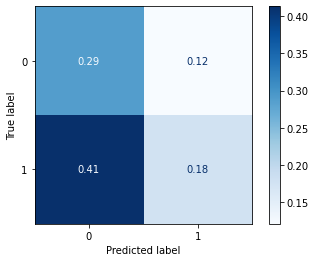

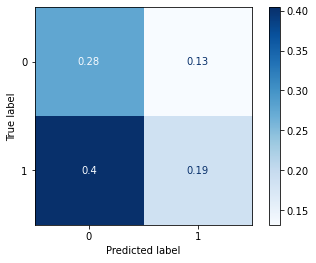

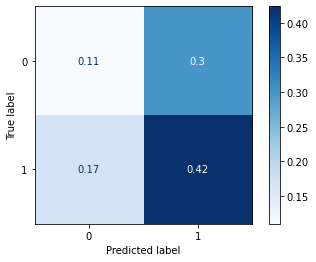

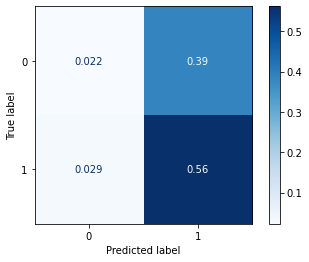

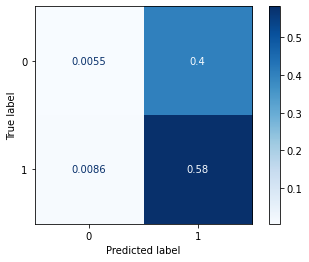

In [120]:
btc_acc_list = []
btc_fscore_list = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  btc_model.fit(btc_X_train , btc_y_train , epochs=100 , verbose=0 , validation_data=(btc_X_val, btc_y_val) ,shuffle=False)

  # predict

  btc_test_pred = btc_model.predict(X_test)

  # generate the metric scores

  y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])

  btc_test_loss, btc_test_accuracy = btc_model.evaluate(X_test, y_test_reshaped, verbose = 0)

  btc_test_pred = btc_test_pred.astype(int).reshape(-1)
  y_test_flat = y_test.astype(int).reshape(-1)

  btc_fscore = f1_score(y_test_flat, btc_test_pred, average='weighted')

  print('BTC Input Test Accuracy: ', float('%.3g' % btc_test_accuracy)*100, '|| BTC Input Test F-score: ', float('%.3g' % btc_fscore), '\n')

  btc_acc_list.append(btc_test_accuracy)
  btc_fscore_list.append(btc_fscore)

  btc_matrix = confusion_matrix(y_test_flat, btc_test_pred, normalize='all')
  btc_matrix_image = ConfusionMatrixDisplay(confusion_matrix=btc_matrix, display_labels=[0,1])
  btc_matrix_image.plot(cmap='Blues') 

print('\nBTC Input - Classification BiLSTM Model -- \nAverage Test Accuracy: ', float('%.3g' % np.mean(btc_acc_list))*100, 
      ' ||  Average Test F-score: ', float('%.3g' % np.mean(btc_fscore_list)))

# **3. LTC Input - Classification Model**

Load the dataset

In [90]:
from google.colab import files
import io
uploaded = files.upload()

Saving ltc_data.csv to ltc_data.csv


In [91]:
ltc_data = pd.read_csv(io.BytesIO(uploaded['ltc_data.csv']), header=None)

In [83]:
ltc_data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (LTC)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (LTC)', 'Buy Quote Volume (USDT)', 'Ignore']

Preprocessing steps

In [84]:
ltc_data['Open Date'] = pd.to_datetime(ltc_data['Open Time'], unit='ms')
ltc_data['Close Date'] = pd.to_datetime(ltc_data['Close Time'], unit='ms')

In [85]:
ltc_data['Close Date'] = ltc_data['Close Date'].dt.normalize()

In [86]:
ltc_data.drop(['Open Time', 'Close Time', 'Ignore', 'Volume (LTC)', 'No. of trades', 'Buy Base Volume (LTC)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [87]:
ltc_data.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [88]:
ltc_data.set_index('Close Date', inplace=True)
ltc_data.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-12-13,272.00,330.00,260.00,290.01,2.770877e+06
2017-12-14,290.01,302.72,252.00,272.40,2.666481e+06
2017-12-15,272.40,314.21,239.99,294.00,4.658824e+06
2017-12-16,294.00,305.00,285.00,293.97,2.674492e+06
2017-12-17,293.01,328.80,290.00,311.40,4.618547e+06


In [89]:
columns = ltc_data.columns.tolist()
columns = columns[-1:] + columns[:-1]
ltc_data = ltc_data[columns]

In [90]:
ltc_data.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-12-13,2.770877e+06,272.00,330.00,260.00,290.01
2017-12-14,2.666481e+06,290.01,302.72,252.00,272.40
2017-12-15,4.658824e+06,272.40,314.21,239.99,294.00
2017-12-16,2.674492e+06,294.00,305.00,285.00,293.97
2017-12-17,4.618547e+06,293.01,328.80,290.00,311.40


In [91]:
ltc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2017-12-13 to 2021-08-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1344 non-null   float64
 1   Open    1344 non-null   float64
 2   High    1344 non-null   float64
 3   Low     1344 non-null   float64
 4   Close   1344 non-null   float64
dtypes: float64(5)
memory usage: 63.0 KB


I have fewer samples in the LTC dataset however I will still be able to create a training set that is the same proportion as the ETH training set.

 ## Create classes

In [92]:
# create a column to indicate the price movement: 1 means the price has increased compared to the previous day, 0 means the price has decreased

ltc_movement = []

for i in range(len(ltc_data)-1):

    if ltc_data['Close'][i+1] < ltc_data['Close'][i]:
        ltc_movement.append(0)
  
    else:
        ltc_movement.append(1)

In [93]:
# datapoint 0 in the dataset will be dropped because there is no price information prior to this day so it can not be put into a class.
ltc_data.drop(ltc_data.index[0], inplace=True)
ltc_data.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-12-14,2.666481e+06,290.01,302.72,252.00,272.40
2017-12-15,4.658824e+06,272.40,314.21,239.99,294.00
2017-12-16,2.674492e+06,294.00,305.00,285.00,293.97
2017-12-17,4.618547e+06,293.01,328.80,290.00,311.40
2017-12-18,5.445728e+06,311.23,360.96,277.00,352.00


In [94]:
ltc_data['Price Movement'] = np.array(ltc_movement) 

In [95]:
ltc_data

,Volume,Open,High,Low,Close,Price Movement
Close Date,,,,,,
2017-12-14,2.666481e+06,290.01,302.72,252.00,272.40,0
2017-12-15,4.658824e+06,272.40,314.21,239.99,294.00,1
2017-12-16,2.674492e+06,294.00,305.00,285.00,293.97,0
2017-12-17,4.618547e+06,293.01,328.80,290.00,311.40,1
2017-12-18,5.445728e+06,311.23,360.96,277.00,352.00,1
...,...,...,...,...,...,...
2021-08-13,2.000749e+08,165.41,184.57,164.00,183.31,1
2021-08-14,1.701896e+08,183.32,185.11,174.62,182.76,0
2021-08-15,1.717747e+08,182.78,186.55,175.18,184.60,1


In [105]:
ltc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1343 entries, 2017-12-14 to 2021-08-17
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volume          1343 non-null   float64
 1   Open            1343 non-null   float64
 2   High            1343 non-null   float64
 3   Low             1343 non-null   float64
 4   Close           1343 non-null   float64
 5   Price Movement  1343 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.4 KB


Split the data into the same sized sets as the ETH data

In [96]:
ltc_split = int(len(ltc_data)*0.6145)
ltc_training_set = ltc_data[:ltc_split]      

ltc_subset = ltc_data[ltc_split:]
ltc_split2 = int(len(ltc_subset)*0.3303)

ltc_val_set = ltc_subset[:ltc_split2]      
ltc_test_set = ltc_subset[ltc_split2:]     


In [97]:
print('LTC Training: ', ltc_training_set.shape, '\nLTC Validation: ', ltc_val_set.shape, '\nLTC Test: ', ltc_test_set.shape)

LTC Training:  (825, 6) 
LTC Validation:  (171, 6) 
LTC Test:  (347, 6)


In [98]:
ltc_X_training = (ltc_training_set.iloc[:, :-1]).values.reshape(ltc_training_set.shape[0],ltc_training_set.shape[1]-1)
ltc_y_training = (ltc_training_set.iloc[:, -1]).values.reshape(ltc_training_set.shape[0],1)

print(ltc_X_training.shape, ltc_y_training.shape)

ltc_X_valid = (ltc_val_set.iloc[:, :-1]).values.reshape(ltc_val_set.shape[0],ltc_val_set.shape[1]-1)
ltc_y_valid = (ltc_val_set.iloc[:, -1]).values.reshape(ltc_val_set.shape[0],1)

print(ltc_X_valid.shape, ltc_y_valid.shape)

ltc_X_testing = (ltc_test_set.iloc[:, :-1]).values.reshape(ltc_test_set.shape[0],ltc_test_set.shape[1]-1)
ltc_y_testing = (ltc_test_set.iloc[:, -1]).values.reshape(ltc_test_set.shape[0],1)

print(ltc_X_testing.shape, ltc_y_testing.shape)

(825, 5) (825, 1)
(171, 5) (171, 1)
(347, 5) (347, 1)


I will check for class imbalance again

In [99]:
print('LTC TRAINING SET\n', 'Count:\n', ltc_training_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',ltc_training_set['Price Movement'].value_counts(normalize=True))
print('\nLTC VALIDATION SET\n', 'Count:\n', ltc_val_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',ltc_val_set['Price Movement'].value_counts(normalize=True))
print('\nLTC TESTING SET\n', 'Count:\n', ltc_test_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',ltc_test_set['Price Movement'].value_counts(normalize=True))


LTC TRAINING SET
 Count:
 0    449
1    376
Name: Price Movement, dtype: int64 

Relative Frequencies:
 0    0.544242
1    0.455758
Name: Price Movement, dtype: float64

LTC VALIDATION SET
 Count:
 1    90
0    81
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.526316
0    0.473684
Name: Price Movement, dtype: float64

LTC TESTING SET
 Count:
 1    191
0    156
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.550432
0    0.449568
Name: Price Movement, dtype: float64


In [100]:
ltc_class_labels = pd.unique(ltc_data['Price Movement'])
ltc_train_count = ltc_training_set['Price Movement'].value_counts()
ltc_val_count = ltc_val_set['Price Movement'].value_counts()
ltc_test_count = ltc_test_set['Price Movement'].value_counts()

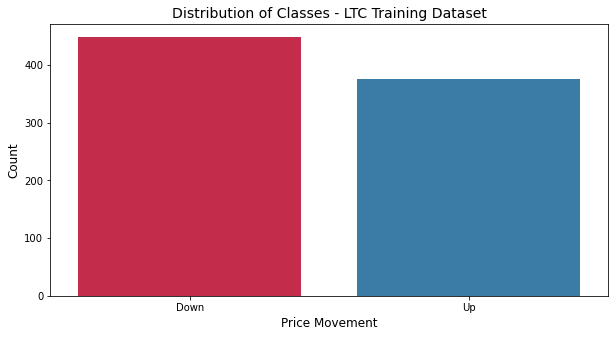

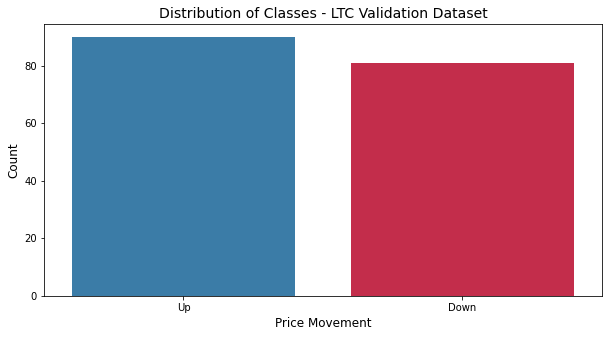

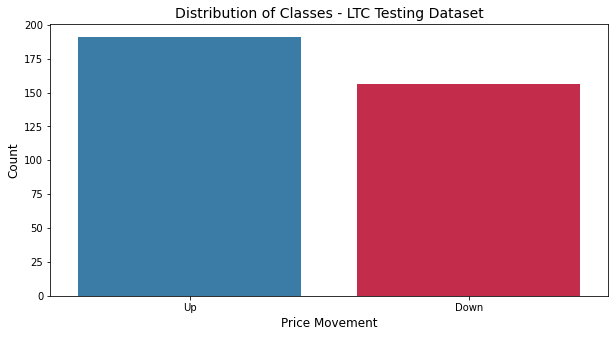

In [103]:
plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= ltc_train_count , palette=["#2980b9" if (x < max(ltc_train_count)) else '#dc143c' for x in ltc_train_count])
plt.title('Distribution of Classes - LTC Training Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Up', 'Down'], y=ltc_val_count , palette=["#dc143c" if (x < max(ltc_val_count)) else '#2980b9' for x in ltc_val_count])
plt.title('Distribution of Classes - LTC Validation Dataset', fontsize=14)
plt.xlabel("Price Movement",fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Up', 'Down'], y=ltc_test_count , palette=["#dc143c" if (x < max(ltc_test_count)) else '#2980b9' for x in ltc_test_count])
plt.title('Distribution of Classes - LTC Testing Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

Normalisation

In [112]:
ltc_Xscaler = MinMaxScaler(feature_range=(0,1))
ltc_yscaler = MinMaxScaler(feature_range=(0,1))

ltc_X_train = ltc_Xscaler.fit_transform(ltc_X_training)
ltc_y_train = ltc_yscaler.fit_transform(ltc_y_training)

ltc_X_val = ltc_Xscaler.fit_transform(ltc_X_valid)
ltc_y_val = ltc_yscaler.fit_transform(ltc_y_valid)

ltc_X_test = ltc_Xscaler.fit_transform(ltc_X_testing)
ltc_y_test = ltc_yscaler.fit_transform(ltc_y_testing)

Preparing the sequences for multistep LSTM

In [113]:
# stack the data horizontally

ltc_train_stacked = np.hstack((ltc_X_train, ltc_y_train))
print ("Stacked LTC Training Data Shape: " , ltc_train_stacked.shape)

ltc_val_stacked = np.hstack((ltc_X_valid, ltc_y_valid))
print ("Stacked LTC Validation Data Shape: " , ltc_val_stacked.shape)

ltc_test_stacked = np.hstack((ltc_X_test, ltc_y_test))
print ("Stacked LTC Test Data Shape: " , ltc_test_stacked.shape)

Stacked LTC Training Data Shape:  (825, 6)
Stacked LTC Validation Data Shape:  (171, 6)
Stacked LTC Test Data Shape:  (347, 6)


In [114]:
# choose a number of time steps 
#n_steps_in, n_steps_out = 14, 14    # same timesteps as ETH

# run function
ltc_X_train, ltc_y_train = create_sequences(ltc_train_stacked, n_steps_in, n_steps_out)
print ("LTC X train sequences: " , ltc_X_train.shape, "LTC y train sequences" , ltc_y_train.shape)      

ltc_X_val, ltc_y_val = create_sequences(ltc_val_stacked, n_steps_in, n_steps_out)
print ("LTC X val sequences: " , ltc_X_val.shape, "LTC y val sequences" , ltc_y_val.shape) 

ltc_X_test, ltc_y_test = create_sequences(ltc_test_stacked, n_steps_in, n_steps_out)
print ("LTC X test sequences: " , ltc_X_test.shape, "LTC y test sequences" , ltc_y_test.shape)    

LTC X train sequences:  (799, 14, 5) LTC y train sequences (799, 14)
LTC X val sequences:  (145, 14, 5) LTC y val sequences (145, 14)
LTC X test sequences:  (321, 14, 5) LTC y test sequences (321, 14)


#### I will create a Bidirectional LSTM Classification Model with the same optimal parameters and architecture selected from hypertuning. This model will be trained on LTC only.

In [115]:
ltc_n_features = ltc_X_train.shape[2]

ltc_model = Sequential()
ltc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), input_shape=(n_steps_in, ltc_n_features), merge_mode='ave'))
ltc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
ltc_model.add(Dropout(0.3))
ltc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
ltc_model.add(Dropout(0.3))
ltc_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
ltc_model.add(Dropout(0.3))
ltc_model.add(TimeDistributed(Dense(1, activation='sigmoid')))
ltc_model.compile(loss='binary_crossentropy' , optimizer=keras.optimizers.Adam(learning_rate= 0.00001) , metrics=['accuracy'])

In [116]:
ltc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 14, 90)            69120     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 14, 90)            130320    
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 90)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 14, 90)            130320    
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 90)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 14, 90)            130320    
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 90)           

#### Train and test the model 5 times to get a list of scores to use for statistical comparison.


Training Number  0
LTC Input Test Accuracy:  58.4 || LTC Input Test F-score:  0.452 


Training Number  1
LTC Input Test Accuracy:  58.699999999999996 || LTC Input Test F-score:  0.449 


Training Number  2
LTC Input Test Accuracy:  58.4 || LTC Input Test F-score:  0.462 


Training Number  3
LTC Input Test Accuracy:  59.099999999999994 || LTC Input Test F-score:  0.451 


Training Number  4
LTC Input Test Accuracy:  59.099999999999994 || LTC Input Test F-score:  0.439 


LTC Input - Classification BiLSTM Model -- 
Average Test Accuracy:  58.699999999999996  ||  Average Test F-score:  0.45


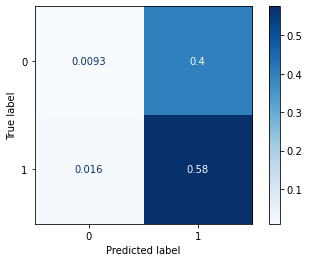

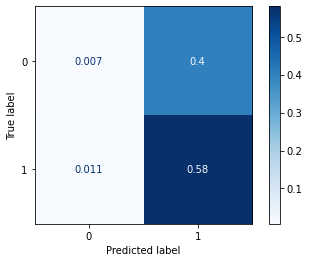

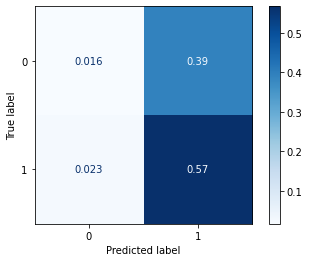

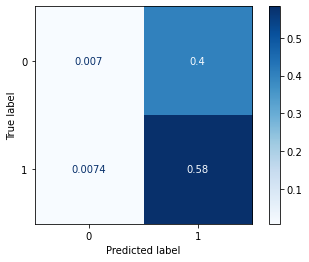

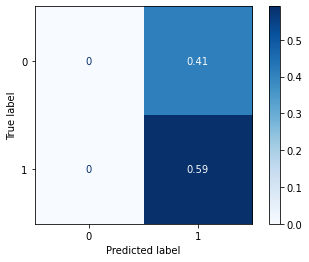

In [119]:
ltc_acc_list = []
ltc_fscore_list = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  ltc_model.fit(ltc_X_train , ltc_y_train , epochs=100 , verbose=0 , validation_data=(ltc_X_val, ltc_y_val) ,shuffle=False)

  # predict

  ltc_test_pred = ltc_model.predict(X_test)

  # generate the metric scores

  y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])

  ltc_test_loss, ltc_test_accuracy = ltc_model.evaluate(X_test, y_test_reshaped, verbose = 0)

  ltc_test_pred = ltc_test_pred.astype(int).reshape(-1)
  y_test_flat = y_test.astype(int).reshape(-1)

  ltc_fscore = f1_score(y_test_flat, ltc_test_pred, average='weighted')

  print('LTC Input Test Accuracy: ', float('%.3g' % ltc_test_accuracy)*100, '|| LTC Input Test F-score: ', float('%.3g' % ltc_fscore), '\n')

  ltc_acc_list.append(ltc_test_accuracy)
  ltc_fscore_list.append(ltc_fscore)

  ltc_matrix = confusion_matrix(y_test_flat, ltc_test_pred, normalize='all')
  ltc_matrix_image = ConfusionMatrixDisplay(confusion_matrix=ltc_matrix, display_labels=[0,1])
  ltc_matrix_image.plot(cmap='Blues') 

print('\nLTC Input - Classification BiLSTM Model -- \nAverage Test Accuracy: ', float('%.3g' % np.mean(ltc_acc_list))*100, 
      ' ||  Average Test F-score: ', float('%.3g' % np.mean(ltc_fscore_list)))

# **4. Keltner Channel Input - Classification Model**

## I want to add the Kelter Channel input to the dataset so I will load the  dataset again for this model as I do not want to alter the original.

In [122]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [123]:
df_kelt = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [124]:
df_kelt.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [125]:
df_kelt['Open Date'] = pd.to_datetime(df_kelt['Open Time'], unit='ms')

In [126]:
df_kelt['Close Date'] = pd.to_datetime(df_kelt['Close Time'], unit='ms')

In [127]:
df_kelt['Close Date'] = df_kelt['Close Date'].dt.normalize()

In [128]:
df_kelt.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [129]:
df_kelt.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [130]:
df_kelt.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [131]:
df_kelt.set_index('Close Date', inplace=True)

In [132]:
columns_kelt = df_kelt.columns.tolist()
columns_kelt = columns_kelt[-1:] + columns_kelt[:-1]
df_kelt = df_kelt[columns_kelt]

In [133]:
df_kelt.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [134]:
df_kelt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


##I will apply the Keltner Channel technical indicator on the close prices of the data to generate a new dataset which includes these new features

In [136]:
kel_indicator = ta.volatility.KeltnerChannel(high=df_kelt['High'], low=df_kelt['Low'], close=df_kelt['Close'], window=20, window_atr=10)
df_kelt['High Band'] = kel_indicator.keltner_channel_hband() 
df_kelt['Low Band'] = kel_indicator.keltner_channel_lband()
df_kelt['Mid Band'] = kel_indicator.keltner_channel_mband()
df_kelt['Channel %'] = kel_indicator.keltner_channel_pband()
df_kelt['Channel Width'] = kel_indicator.keltner_channel_wband()

In [137]:
columns2_kelt = df_kelt.columns.tolist()
columns2_kelt = columns2_kelt[-5:] + columns2_kelt[:-5]
df_kelt = df_kelt[columns2_kelt]
print(columns2_kelt)

['High Band', 'Low Band', 'Mid Band', 'Channel %', 'Channel Width', 'Volume', 'Open', 'High', 'Low', 'Close']


In [138]:
df_kelt # some of the new features contain null values due to the indicator requiring initialisation using a few datapoints. I will drop these rows.

,High Band,Low Band,Mid Band,Channel %,Channel Width,Volume,Open,High,Low,Close
Close Date,,,,,,,,,,
2017-08-17,318.240000,289.880000,NaN,0.427362,NaN,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,321.326667,279.296667,NaN,0.348878,NaN,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,318.052222,275.432222,NaN,0.363158,NaN,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,316.499167,275.694167,NaN,0.573602,NaN,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,327.877333,274.465333,NaN,0.914114,NaN,1.689472e+06,299.10,346.52,294.60,323.29
...,...,...,...,...,...,...,...,...,...,...
2021-06-24,2571.482333,2138.745333,2355.113833,-0.344841,18.374356,1.377800e+09,1967.95,2036.61,1884.79,1989.52
2021-06-25,2530.075500,2100.925500,2315.500500,-0.680661,18.533790,1.612557e+09,1989.53,2019.99,1791.22,1808.82
2021-06-26,2485.780167,2056.182167,2270.981167,-0.527335,18.916846,1.478551e+09,1808.97,1852.80,1717.32,1829.64


In [139]:
df_kelt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   High Band      1412 non-null   float64
 1   Low Band       1412 non-null   float64
 2   Mid Band       1393 non-null   float64
 3   Channel %      1412 non-null   float64
 4   Channel Width  1393 non-null   float64
 5   Volume         1412 non-null   float64
 6   Open           1412 non-null   float64
 7   High           1412 non-null   float64
 8   Low            1412 non-null   float64
 9   Close          1412 non-null   float64
dtypes: float64(10)
memory usage: 121.3 KB


In [140]:
df_kelt.dropna(inplace=True)

In [141]:
df_kelt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1393 entries, 2017-09-05 to 2021-06-28
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   High Band      1393 non-null   float64
 1   Low Band       1393 non-null   float64
 2   Mid Band       1393 non-null   float64
 3   Channel %      1393 non-null   float64
 4   Channel Width  1393 non-null   float64
 5   Volume         1393 non-null   float64
 6   Open           1393 non-null   float64
 7   High           1393 non-null   float64
 8   Low            1393 non-null   float64
 9   Close          1393 non-null   float64
dtypes: float64(10)
memory usage: 119.7 KB


# Create classes

In [142]:
# create a column to indicate the price movement: 1 means the price has increased compared to the previous day, 0 means the price has decreased

movement_kelt = []

for i in range(len(df_kelt)-1):

  if df_kelt['Close'][i+1] < df_kelt['Close'][i]:
    movement_kelt.append(0)
  
  else:
    movement_kelt.append(1)


In [143]:
# datapoint 0 in the dataset will be dropped because there is no price information prior to this day so it can not be put into a class.
df_kelt.drop(df_kelt.index[0], inplace=True)
df_kelt.head()

,High Band,Low Band,Mid Band,Channel %,Channel Width,Volume,Open,High,Low,Close
Close Date,,,,,,,,,,
2017-09-06,368.531167,289.249167,328.890167,0.577065,24.105920,1.793963e+06,313.29,336.34,312.09,335.00
2017-09-07,370.046333,291.316333,330.681333,0.548376,23.808420,1.027136e+06,335.01,342.50,320.17,334.49
2017-09-08,372.794333,289.944333,331.369333,0.157461,25.002314,1.494310e+06,334.49,335.10,272.00,302.99
2017-09-09,373.226000,289.610000,331.418000,0.085271,25.229770,8.137504e+05,300.01,307.00,281.66,296.74
2017-09-10,370.932500,288.333500,329.633000,0.062549,25.057867,1.181904e+06,296.72,302.78,261.03,293.50


In [144]:
df_kelt['Price Movement'] = np.array(movement_kelt)

# Split dataset into training, validation and testing datasets

 
#### 61.45% of the data will be used for training, 12.7% will be used as the validation set and the remaining 25.85% will be used as the test set

In [145]:
split_kelt = int(len(df_kelt)*0.6145)
kelt_training_set = df_kelt[:split_kelt]      # 18/8/2017 - 1/1/2020

kelt_subset = df_kelt[split_kelt:]
split2_kelt = int(len(kelt_subset)*0.3303)

kelt_val_set = kelt_subset[:split2_kelt]      # 2/1/2020 - 28/6/2020
kelt_test_set = kelt_subset[split2_kelt:]     # 29/6/2020 - 28/6/2021

In [146]:
print('Training: ', kelt_training_set.shape, '\nValidation: ', kelt_val_set.shape, '\nTest: ', kelt_test_set.shape)

Training:  (855, 11) 
Validation:  (177, 11) 
Test:  (360, 11)


# Split the data into X variables and y targets

In [147]:
kelt_X_training = (kelt_training_set.iloc[:, :-1]).values.reshape(kelt_training_set.shape[0],kelt_training_set.shape[1]-1)
kelt_y_training = (kelt_training_set.iloc[:, -1]).values.reshape(kelt_training_set.shape[0],1)

print(kelt_X_training.shape, kelt_y_training.shape)

kelt_X_valid = (kelt_val_set.iloc[:, :-1]).values.reshape(kelt_val_set.shape[0],kelt_val_set.shape[1]-1)
kelt_y_valid = (kelt_val_set.iloc[:, -1]).values.reshape(kelt_val_set.shape[0],1)

print(kelt_X_valid.shape, kelt_y_valid.shape)

kelt_X_testing = (kelt_test_set.iloc[:, :-1]).values.reshape(kelt_test_set.shape[0],kelt_test_set.shape[1]-1)
kelt_y_testing = (kelt_test_set.iloc[:, -1]).values.reshape(kelt_test_set.shape[0],1)

print(kelt_X_testing.shape, kelt_y_testing.shape)

(855, 10) (855, 1)
(177, 10) (177, 1)
(360, 10) (360, 1)


### The proportion of 'down' to 'up' classes in the dataset will be the same as the original dataset so I won't check for class imbalance again here


# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler from scikit-learn to do this.
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [148]:
kelt_Xscaler = MinMaxScaler(feature_range=(0,1))
kelt_yscaler = MinMaxScaler(feature_range=(0,1))

kelt_X_train = kelt_Xscaler.fit_transform(kelt_X_training)
kelt_y_train = kelt_yscaler.fit_transform(kelt_y_training)

kelt_X_val = kelt_Xscaler.fit_transform(kelt_X_valid)
kelt_y_val = kelt_yscaler.fit_transform(kelt_y_valid)

kelt_X_test = kelt_Xscaler.fit_transform(kelt_X_testing)
kelt_y_test = kelt_yscaler.fit_transform(kelt_y_testing)

## Prepare data for multi-step LSTM
##### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [149]:
# stack the data horizontally

kelt_train_stacked = np.hstack((kelt_X_training, kelt_y_training))
print ("Stacked (Keltner Channel Input) Training Data Shape: " , kelt_train_stacked.shape)

kelt_val_stacked = np.hstack((kelt_X_valid, kelt_y_valid))
print ("Stacked (Keltner Channel Input) Validation Data Shape: " , kelt_val_stacked.shape)

kelt_test_stacked = np.hstack((kelt_X_testing, kelt_y_testing))
print ("Stacked (Keltner Channel Input) Test Data Shape: " , kelt_test_stacked.shape)

Stacked (Keltner Channel Input) Training Data Shape:  (855, 11)
Stacked (Keltner Channel Input) Validation Data Shape:  (177, 11)
Stacked (Keltner Channel Input) Test Data Shape:  (360, 11)


In [150]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 14

# run function
kelt_X_train, kelt_y_train = create_sequences(kelt_train_stacked, n_steps_in, n_steps_out)
print ("X train sequences (Keltner Channel Input): " , kelt_X_train.shape, "y train sequences (Keltner Channel Input): " , kelt_y_train.shape)            

kelt_X_val, kelt_y_val = create_sequences(kelt_val_stacked, n_steps_in, n_steps_out)
print ("X val sequences (Keltner Channel Input): " , kelt_X_val.shape, "y val sequences (Keltner Channel Input): " , kelt_y_val.shape) 

kelt_X_test, kelt_y_test = create_sequences(kelt_test_stacked, n_steps_in, n_steps_out)
print ("X test sequences (Keltner Channel Input): " , kelt_X_test.shape, "y test sequences (Keltner Channel Input): " , kelt_y_test.shape)      

X train sequences (Keltner Channel Input):  (829, 14, 10) y train sequences (Keltner Channel Input):  (829, 14)
X val sequences (Keltner Channel Input):  (151, 14, 10) y val sequences (Keltner Channel Input):  (151, 14)
X test sequences (Keltner Channel Input):  (334, 14, 10) y test sequences (Keltner Channel Input):  (334, 14)


#### I will create a Bidirectional LSTM Classification Model with the same optimal parameters and architecture selected from hypertuning. This model will be trained on the dataset that contains the Keltner Channel Input.

In [151]:
kelt_n_features = kelt_X_train.shape[2]

kelt_model = Sequential()
kelt_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), input_shape=(n_steps_in, kelt_n_features), merge_mode='ave'))
kelt_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
kelt_model.add(Dropout(0.3))
kelt_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
kelt_model.add(Dropout(0.3))
kelt_model.add(Bidirectional(LSTM(units=90, activation='relu', return_sequences=True), merge_mode='ave'))
kelt_model.add(Dropout(0.3))
kelt_model.add(TimeDistributed(Dense(1, activation='sigmoid')))
kelt_model.compile(loss='binary_crossentropy' , optimizer=keras.optimizers.Adam(learning_rate= 0.00001) , metrics=['accuracy'])

In [152]:
kelt_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 14, 90)            72720     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 14, 90)            130320    
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 90)            0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 14, 90)            130320    
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 90)            0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 14, 90)            130320    
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 90)           

### Train and test the model 5 times to get a list of scores to use later for statistical comparison.


Training Number  0
Test Accuracy:  47.199999999999996 || Test F-score:  0.459 


Training Number  1
Test Accuracy:  48.699999999999996 || Test F-score:  0.478 


Training Number  2
Test Accuracy:  46.300000000000004 || Test F-score:  0.451 


Training Number  3
Test Accuracy:  47.4 || Test F-score:  0.456 


Training Number  4
Test Accuracy:  47.3 || Test F-score:  0.46 


Keltner Channel Input - Classification BiLSTM Model -- 
Average Test Accuracy:  47.4  ||  Average Test F-score:  0.461


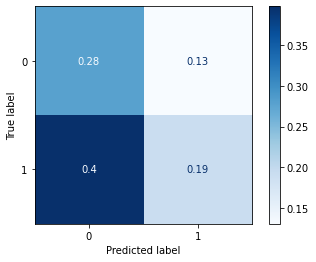

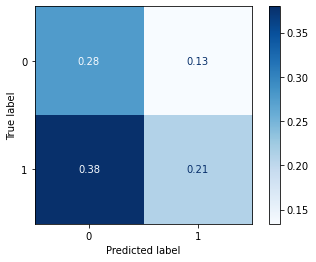

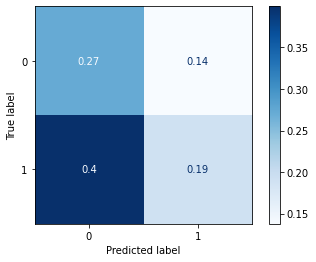

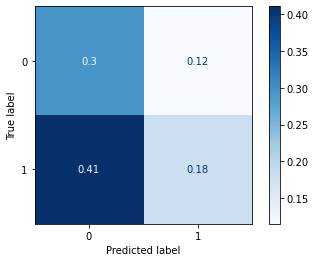

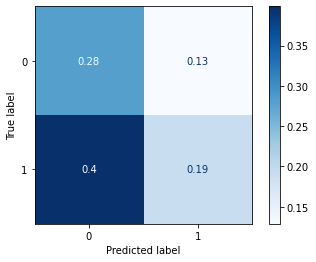

In [155]:
kelt_acc_list = []
kelt_fscore_list = []

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  kelt_model.fit(kelt_X_train , kelt_y_train , epochs=100 , verbose=0 , validation_data=(kelt_X_val, kelt_y_val) ,shuffle=False)

  #predict

  kelt_test_pred = kelt_model.predict(kelt_X_test)

  # generate the metric scores

  kelt_y_test_reshaped = kelt_y_test.reshape(kelt_y_test.shape[0], kelt_y_test.shape[1])

  kelt_test_loss, kelt_test_accuracy = kelt_model.evaluate(kelt_X_test, kelt_y_test_reshaped, verbose = 0)

  kelt_test_pred = kelt_test_pred.astype(int).reshape(-1)
  kelt_y_test_flat = kelt_y_test.astype(int).reshape(-1)

  kelt_fscore = f1_score(kelt_y_test_flat, kelt_test_pred, average='weighted')

  print('Test Accuracy: ', float('%.3g' % kelt_test_accuracy)*100, '|| Test F-score: ', float('%.3g' % kelt_fscore), '\n')

  kelt_acc_list.append(kelt_test_accuracy)
  kelt_fscore_list.append(kelt_fscore)

  kelt_matrix = confusion_matrix(kelt_y_test_flat, kelt_test_pred, normalize='all')
  kelt_matrix_image = ConfusionMatrixDisplay(confusion_matrix=kelt_matrix, display_labels=[0,1])
  kelt_matrix_image.plot(cmap='Blues') 

print('\nKeltner Channel Input - Classification BiLSTM Model -- \nAverage Test Accuracy: ', float('%.3g' % np.mean(kelt_acc_list))*100, 
      ' ||  Average Test F-score: ', float('%.3g' % np.mean(kelt_fscore_list)))


# **Statistical comparison of results**
##### The dataset was determined to be non-parametric during the Exploratory Data Analysis stage. The models also have been trained on different training sets therefore I will be using a non-parametric, unpaired statistical hypothesis test to compare the performance of the baseline models with the models that have had additonal input.
##### I will be using the Mann-Whitney U Test from the SciPy Stats module on the scores for each of the models https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

*   If p <= 0.05 then the null hypothesis is rejected. There is a statistically significant difference between the performances of the models.
*   If p > 0.05 then we accept the null hypothesis that there is no significant difference between the two performances and any potential differences are by chance.



In [157]:
# BTC model vs Baseline
# Accuracy
stat1a, p1a = mannwhitneyu(acc_list, btc_acc_list)
print('BTC Model: Accuracy p-value is ', float('%.3g' % p1a))
# F1-Score
stat1b, p1b = mannwhitneyu(fscore_list, btc_fscore_list)
print('BTC Model: F1-Score p-value is ', float('%.3g' % p1b))

# LTC model vs Baseline
# Accuracy
stat2a, p2a = mannwhitneyu(acc_list, ltc_acc_list)
print('\nLTC Model: Accuracy p-value is ', float('%.3g' % p2a))
# F1-Score
stat2b, p2b = mannwhitneyu(fscore_list, ltc_fscore_list)
print('LTC Model: F1-Score p-value is ', float('%.3g' % p2b))

# Keltner Channel model vs Baseline
# Accuracy
stat3a, p3a = mannwhitneyu(acc_list, kelt_acc_list)
print('\nKeltner Channel Model: Accuracy p-value is ', float('%.3g' % p3a))
# F1-Score
stat3b, p3b = mannwhitneyu(fscore_list, kelt_fscore_list)
print('Keltner Channel Model: F1-Score p-value is ', float('%.3g' % p3b))

BTC Model: Accuracy p-value is  0.338
BTC Model: F1-Score p-value is  0.0184

LTC Model: Accuracy p-value is  0.00596
LTC Model: F1-Score p-value is  0.00609

Keltner Channel Model: Accuracy p-value is  0.00596
Keltner Channel Model: F1-Score p-value is  0.00609
